# A guide to paticle motion estimation with `pyusel-dispest`

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from timuscle.dataio import loadHDF5asdict

# Define the test data

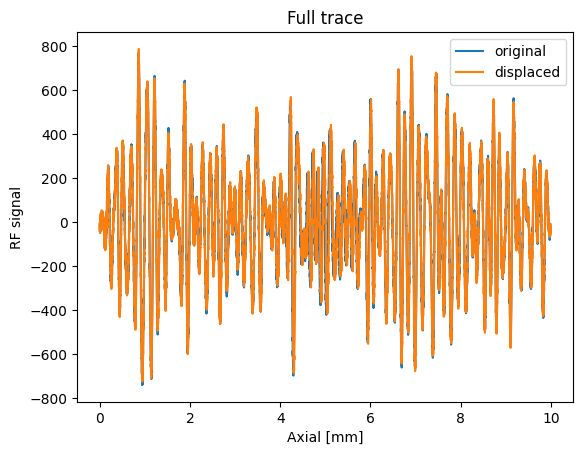

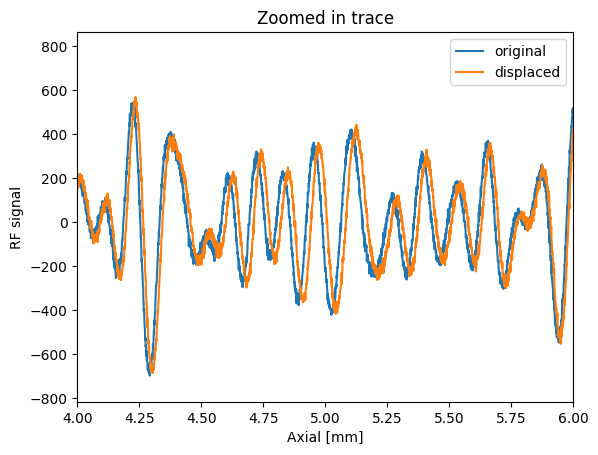

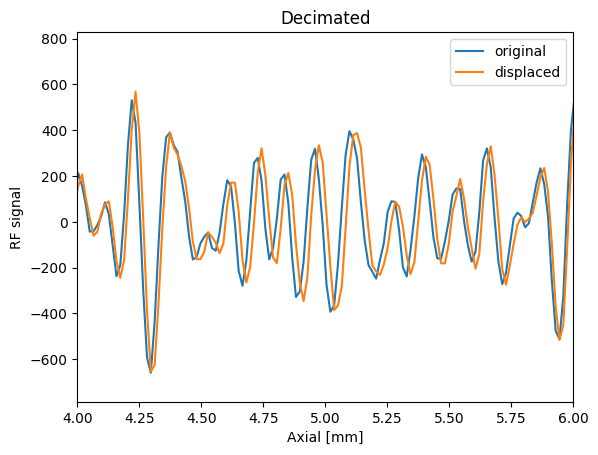

In [2]:
tracking_data = loadHDF5asdict("example_data.h5")['tracking_data']

fs  = tracking_data['fs']
fc  = tracking_data['fc']
c   = tracking_data['c']
t   = tracking_data['t']
x   = c*t/2

disp0 = tracking_data['disp0']
rng = np.random.default_rng(12345)
trace0, trace1 = tracking_data['traces'] + rng.normal(0, 0.01*np.ptp(tracking_data['traces']), tracking_data['traces'].shape)

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Full trace")
plt.show()

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Zoomed in trace")
plt.xlim(4, 6)
plt.show()

plt.figure()
plt.plot(1E3*x[::20], trace0[::20], label='original')
plt.plot(1E3*x[::20], trace1[::20], label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Decimated")
plt.xlim(4, 6)
plt.show()

In [3]:
env = np.abs(sig.hilbert(trace0))
speckle_snr = np.mean(env[100:-100])/np.std(env[100:-100])
print(speckle_snr)

2.0023885824338055


## Displacement estimation using Kasai algorithm

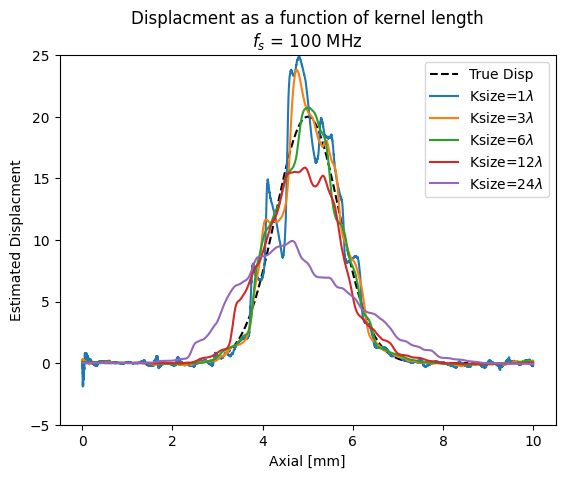

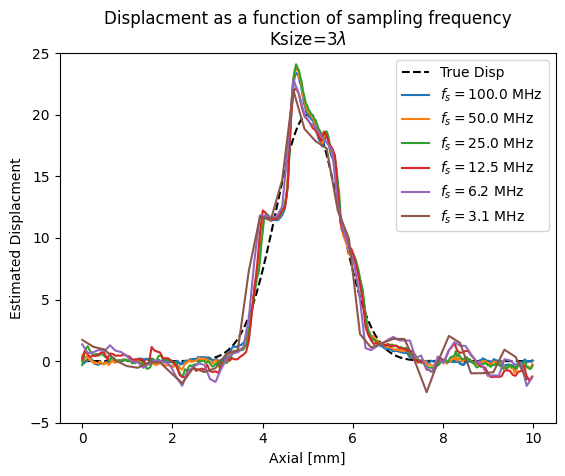

In [4]:
from dispest import calc_kasai

# convert rfsignal to IQ to get phase information
IQ0 = sig.hilbert(trace0).reshape((-1,1))
IQ1 = sig.hilbert(trace1).reshape((-1,1))
IQ = np.concatenate((IQ0, IQ1), axis=1)
I = np.real(IQ)
Q = np.imag(IQ)

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*disp0, color='k', linestyle='--', label='True Disp')

disps = []
for lam in [1, 3, 6, 12, 24]:
    ksize = int(np.round(lam*fs/(fc)))
    disp = calc_kasai(I, Q, taxis=1, fd=fc, c=c, ksize=ksize, kaxis=0)
    plt.plot(1E3*x, disp, linestyle='-', label=  f"Ksize={lam}" + '$\\lambda $')

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of kernel length\n$f_s$ = 100 MHz")
plt.show()

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*disp0, color='k', linestyle='--', label='True Disp')

disps = []
lam=3
for dec in [10, 20, 40, 80, 160, 320]:
    ksize = int(np.ceil(lam*fs/(dec*fc)))
    disp = calc_kasai(I[::dec,:], Q[::dec,:], taxis=1, fd=fc, c=c, ksize=ksize, kaxis=0)
    plt.plot(1E3*x[::dec], disp, linestyle='-', label=  "$f_s=" + f"{fs/(1E6*dec):0.01f}" + "$ MHz")

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of sampling frequency\nKsize=3$\\lambda$")
plt.show()


# Normalized Cross correlation

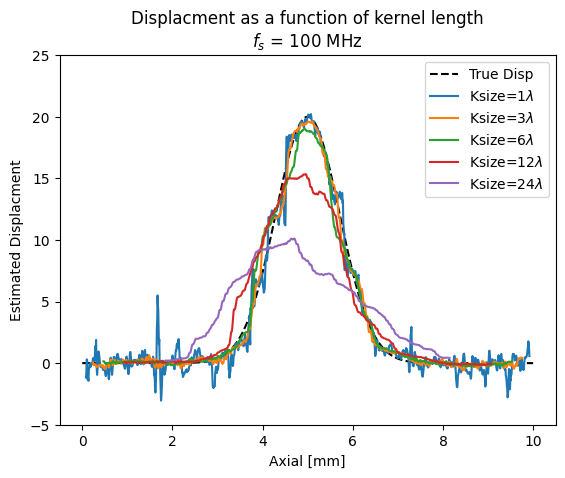

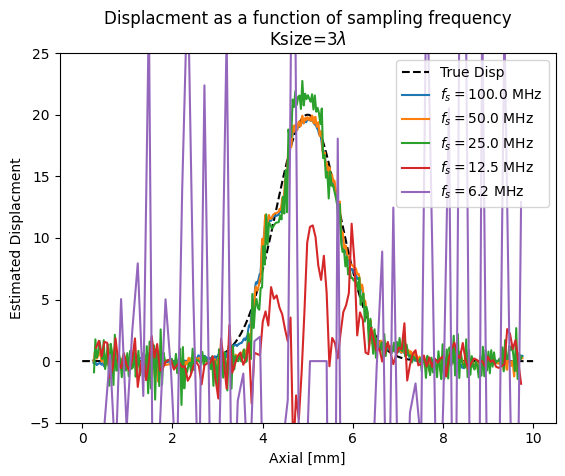

In [5]:
from dispest import get_xcorr_inds, nxcorr_by_inds_mu

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*disp0, color='k', linestyle='--', label='True Disp')

disps = []
dec = 10
ilam = int(np.ceil(fs/(dec*fc)))
rhos = []
xests = []
for lam in [1, 3, 6, 12, 24]:
    ksize = int(np.ceil(lam*fs/(dec*fc)))
    t0dec = trace0[::dec]
    t1dec = trace1[::dec]

    selref, selser, outbnd, seliref, imid = get_xcorr_inds(len(t0dec), ksize, 1, ilam//2)

    ilag, dlag, rho = nxcorr_by_inds_mu(t0dec, t1dec, selref, selser, outbnd, seliref)
    rhos.append(rhos)
    dx = 1E6*dec*c*(ilag+dlag)/(2*fs)
    disps.append(dx)
    xest = 1E3*c*dec*imid/(2*fs)
    xests.append(xest)

    plt.plot(xest, dx, label=  f"Ksize={lam}" + '$\\lambda $')

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of kernel length\n$f_s$ = 100 MHz")
plt.show()

dxs_cpu = disps
rhos_cpu = rhos
xms_cpu = xests

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*disp0, color='k', linestyle='--', label='True Disp')


disps = []
lam=3
rhos = []
for dec in [10, 20, 40, 80, 160]:
    ksize = int(np.ceil(lam*fs/(dec*fc)))
    ilam = int(np.ceil(fs/(dec*fc)))
    t0dec = trace0[::dec]
    t1dec = trace1[::dec]

    selref, selser, outbnd, seliref, imid = get_xcorr_inds(len(t0dec), ksize, 1, ilam//2)

    ilag, dlag, rho = nxcorr_by_inds_mu(t0dec, t1dec, selref, selser, outbnd, seliref)
    rhos.append(rhos)
    dx = 1E6*dec*c*(ilag+dlag)/(2*fs)
    xest = 1E3*c*dec*imid/(2*fs)

    plt.plot(xest, dx, label="$f_s=" + f"{fs/(1E6*dec):0.01f}" + "$ MHz")

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of sampling frequency\nKsize=3$\\lambda$")
plt.show()

# Normalized cross correlation the GPU version

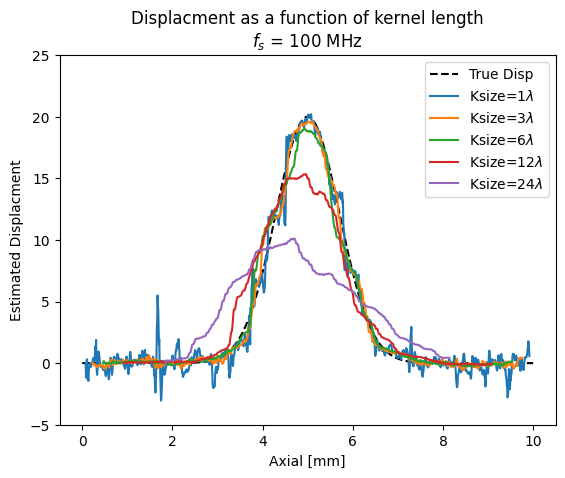

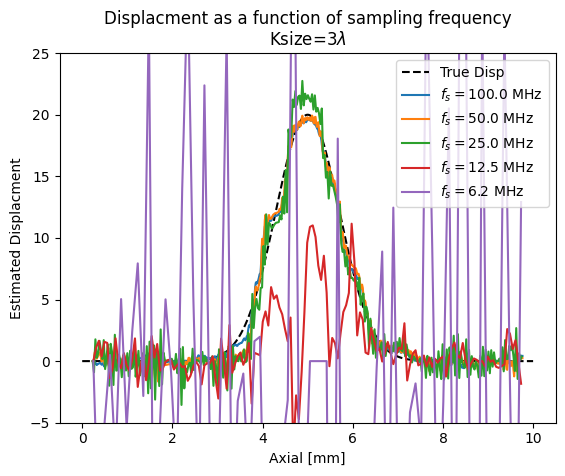

In [6]:
from dispest import nxcorr_gpu

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*disp0, color='k', linestyle='--', label='True Disp')

disps = []
dec = 10
ilam = int(np.ceil(fs/(dec*fc)))
rhos = []
xests = []
for lam in [1, 3, 6, 12, 24]:
    ksize = int(np.ceil(lam*fs/(dec*fc)))
    t0dec = trace0[::dec]
    t1dec = trace1[::dec]

    dxsamp, rho, imid = nxcorr_gpu(t0dec, t1dec, ksize, 1, ilam//2)
    rhos.append(rho)
    dx = 1E6*dec*c*(dxsamp)/(2*fs)
    disps.append(dx)
    xest = 1E3*c*dec*imid/(2*fs)
    xests.append(xest)

    plt.plot(xest, dx, label=  f"Ksize={lam}" + '$\\lambda $')

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of kernel length\n$f_s$ = 100 MHz")
plt.show()

dxs_gpu = disps
rhos_gpu = rhos
xms_gpu = xests

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*disp0, color='k', linestyle='--', label='True Disp')


disps = []
lam=3
rhos = []
for dec in [10, 20, 40, 80, 160]:
    ksize = int(np.ceil(lam*fs/(dec*fc)))
    ilam = int(np.ceil(fs/(dec*fc)))
    t0dec = trace0[::dec]
    t1dec = trace1[::dec]

    dxsamp, rho, imid = nxcorr_gpu(t0dec, t1dec, ksize, 1, ilam//2)
    rhos.append(rhos)
    dx = 1E6*dec*c*(dxsamp)/(2*fs)
    xest = 1E3*c*dec*imid/(2*fs)

    plt.plot(xest, dx, label="$f_s=" + f"{fs/(1E6*dec):0.01f}" + "$ MHz")

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of sampling frequency\nKsize=3$\\lambda$")
plt.show()

# Verify CPU and GPU implementations get the same answer

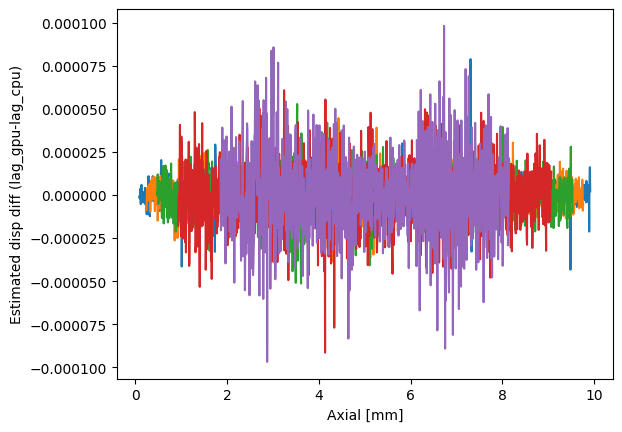

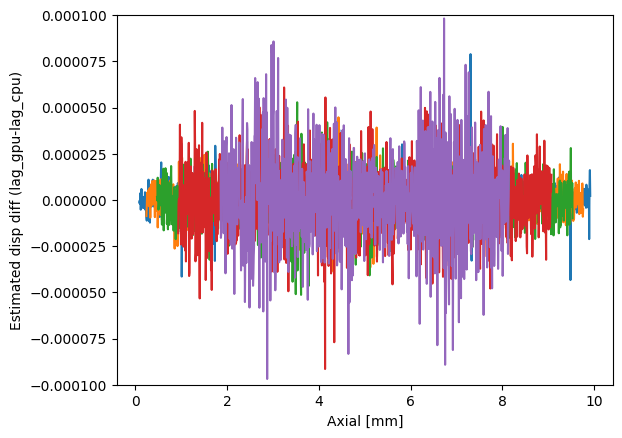

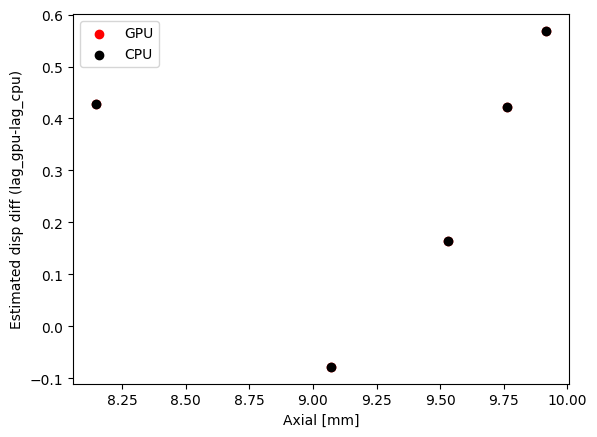

In [7]:
lag_diffs = []
plt.figure()
for lag_cpu, lag_gpu, x_cpu in zip(dxs_cpu, dxs_gpu, xms_cpu):
    plt.plot(x_cpu, lag_gpu-lag_cpu)
plt.xlabel("Axial [mm]")
plt.ylabel("Estimated disp diff (lag_gpu-lag_cpu)")
plt.show()

lag_diffs = []
plt.figure()
for lag_cpu, lag_gpu, x_cpu in zip(dxs_cpu, dxs_gpu, xms_cpu):
    plt.plot(x_cpu, lag_gpu-lag_cpu)
plt.xlabel("Axial [mm]")
plt.ylabel("Estimated disp diff (lag_gpu-lag_cpu)")
plt.ylim(-1E-4, 1E-4)
plt.show()

plt.figure()
plotlabels = True
for lag_cpu, lag_gpu, x_cpu in zip(dxs_cpu, dxs_gpu, xms_cpu):
    if plotlabels:
        plt.scatter(x_cpu[-1], lag_gpu[-1], color='red', label='GPU')
        plt.scatter(x_cpu[-1], lag_cpu[-1], color='black', label='CPU')
        plotlabels=False
    else:
        plt.scatter(x_cpu[-1], lag_gpu[-1], color='red')
        plt.scatter(x_cpu[-1], lag_cpu[-1], color='black')

plt.xlabel("Axial [mm]")
plt.ylabel("Estimated disp diff (lag_gpu-lag_cpu)")
plt.legend()
# plt.ylim(-1E-4, 1E-4)
plt.show()

# Try AB-AA subtraction

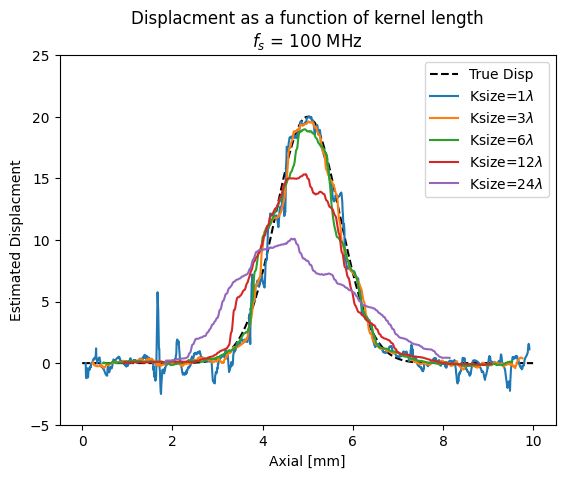

In [8]:
from dispest import nxcorr_gpu

# calculate displacement with different kernel lengths
plt.figure()
plt.plot(1E3*x, 1E6*disp0, color='k', linestyle='--', label='True Disp')

disps = []
dec = 10
c = 1540
ilam = int(np.ceil(fs/(dec*fc)))
rhos = []
xests = []
for lam in [1, 3, 6, 12, 24]:
    ksize = int(np.ceil(lam*fs/(dec*fc)))
    t0dec = trace0[::dec]
    t1dec = trace1[::dec]

    dxsamp, rho, imid = nxcorr_gpu(np.array([t0dec, t0dec]), np.array([t0dec, t1dec]), ksize, 1, ilam//2)
    rhos.append(rho)
    dx = 1E6*dec*c*(dxsamp[1]-dxsamp[0])/(2*fs)
    disps.append(dx)
    xest = 1E3*c*dec*imid/(2*fs)
    xests.append(xest)

    plt.plot(xest, dx, label=  f"Ksize={lam}" + '$\\lambda $')

plt.legend()
plt.ylim(-5, 25)
plt.ylabel("Estimated Displacment")
plt.xlabel("Axial [mm]")
plt.title("Displacment as a function of kernel length\n$f_s$ = 100 MHz")
plt.show()